In [85]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.optim import Adam, ClippedAdam
from pyro.contrib.autoguide import AutoNormal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

### Load and process data

In [58]:
# Load the data set
data = pd.read_csv('data/dataset.csv')

# Binary mapping
binary_map = {
    "Attrition": {"No": 0, "Yes": 1},
    "Gender": {"Male": 0, "Female": 1},
    "OverTime": {"No": 0, "Yes": 1},
    "Over18": {"N": 0, "Y": 1}
}

for col, mapping in binary_map.items():
    if col in data.columns:
        data[col] = data[col].map(mapping)

# One-hot encoding for multi-class categorical columns
categorical_cols = ["BusinessTravel", "Department", "EducationField", "JobRole", "MaritalStatus"]
data = pd.get_dummies(data, columns=categorical_cols)

# Convert all boolean dummies to integers (so NumPy can process them)
data = data.astype({col: int for col in data.select_dtypes(include='bool').columns})

# Basic Summary Statistics
print(data.describe())

               Age    Attrition    DailyRate  DistanceFromHome    Education  \
count  1470.000000  1470.000000  1470.000000       1470.000000  1470.000000   
mean     36.923810     0.161224   802.485714          9.192517     2.912925   
std       9.135373     0.367863   403.509100          8.106864     1.024165   
min      18.000000     0.000000   102.000000          1.000000     1.000000   
25%      30.000000     0.000000   465.000000          2.000000     2.000000   
50%      36.000000     0.000000   802.000000          7.000000     3.000000   
75%      43.000000     0.000000  1157.000000         14.000000     4.000000   
max      60.000000     1.000000  1499.000000         29.000000     5.000000   

       EmployeeCount  EmployeeNumber  EnvironmentSatisfaction       Gender  \
count         1470.0     1470.000000              1470.000000  1470.000000   
mean             1.0     1024.865306                 2.721769     0.400000   
std              0.0      602.024335                 1

### Correlation

In [63]:
# Print list of features with more than 70% correlation
def get_high_correlation_features(data, threshold=0.7):
    corr = data.corr()
    high_corr_var = np.where(corr > threshold)
    high_corr_var = [(corr.columns[x], corr.columns[y], corr.iloc[x, y])
                     for x, y in zip(*high_corr_var)
                     if x != y and x < y]
    return high_corr_var

high_corr_features = get_high_correlation_features(data, threshold=0.7)

print("Features with correlation greater than 0.7:")
for f1, f2, value in high_corr_features:
    print(f"{f1} - {f2}: {value:.2f}")

Features with correlation greater than 0.7:
JobLevel - MonthlyIncome: 0.95
JobLevel - TotalWorkingYears: 0.78
MonthlyIncome - TotalWorkingYears: 0.77
PercentSalaryHike - PerformanceRating: 0.77
YearsAtCompany - YearsInCurrentRole: 0.76
YearsAtCompany - YearsWithCurrManager: 0.77
YearsInCurrentRole - YearsWithCurrManager: 0.71
Department_Human Resources - JobRole_Human Resources: 0.90
Department_Sales - JobRole_Sales Executive: 0.81


In [66]:
# Delete variables with high correlation 
data = data.drop(columns=[
    "MonthlyIncome",
    "TotalWorkingYears",
    "PerformanceRating",
    "YearsInCurrentRole",
    "YearsWithCurrManager",
    "Department_Human Resources",
    "Department_Sales"
])

### Distribution of the target variable

In [67]:
data["Attrition"].value_counts(normalize=True)

Attrition
0    0.838776
1    0.161224
Name: proportion, dtype: float64

### PPCA

In [68]:
np.random.seed(42)

# Drop column we are predicting "Attrition"
target = data["Attrition"]
data = data.drop(columns=["Attrition"])

# Standardize safely
X_np = data.to_numpy()
X_mean = np.nanmean(X_np, axis=0)
X_std = np.nanstd(X_np, axis=0)

# Avoid division by zero
X_std[X_std == 0] = 1.0

X = (X_np - X_mean) / X_std
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
X = torch.tensor(X, dtype=torch.float32)

# Set latent dimension
latent_dim = 2

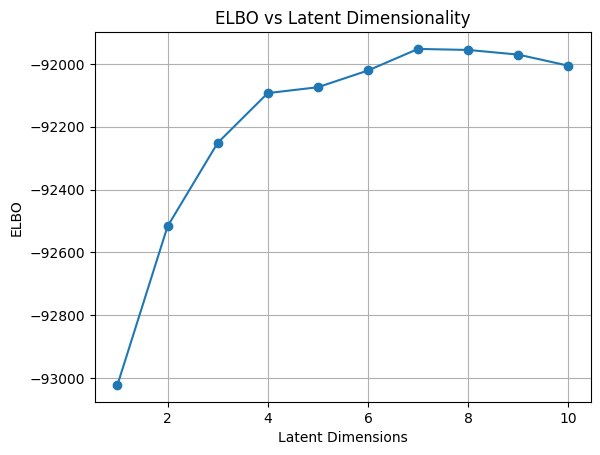

Best latent dimension selected: 7


In [71]:
# Define PPCA model
def ppca_model(X, latent_dim):
    N, D = X.shape
    W = pyro.sample("W", dist.Normal(0, 1).expand([D, latent_dim]).to_event(2))
    sigma  = pyro.sample("sigma",  dist.HalfCauchy(1)) 
    
    with pyro.plate("data", N):
        z = pyro.sample("z", dist.Normal(0, 1).expand([latent_dim]).to_event(1))
        loc = torch.matmul(z, W.T)
        pyro.sample("obs", dist.Normal(loc, sigma).to_event(1), obs=X)

# Search for best latent dimension
best_latent_dim = None
best_elbo = float('-inf')
best_z_loc = None

elbos = []
dims = list(range(1, 11))  # Dimensions from 1 to 10

for latent_dim in dims:
    pyro.clear_param_store()
    
    def model_wrapped(X):
        return ppca_model(X, latent_dim)

    guide = AutoNormal(model_wrapped)
    optimizer = Adam({"lr": 0.01})
    svi = SVI(model_wrapped, guide, optimizer, loss=Trace_ELBO())
    
    num_steps = 1000
    final_loss = None
    for step in range(num_steps):
        loss = svi.step(X)
        final_loss = loss
    elbo = -final_loss
    elbos.append(elbo)

    if elbo > best_elbo:
        best_elbo = elbo
        best_latent_dim = latent_dim
        best_z_loc = guide(X)["z"].detach().numpy()

# Plot ELBO vs latent dimensions
plt.plot(dims, elbos, marker='o')
plt.xlabel('Latent Dimensions')
plt.ylabel('ELBO')
plt.title('ELBO vs Latent Dimensionality')
plt.grid(True)
plt.show()

print(f"Best latent dimension selected: {best_latent_dim}")

# Merge with target
reduced_df = pd.DataFrame(best_z_loc, columns=[f"z{i+1}" for i in range(best_latent_dim)])
reduced_df["Attrition"] = target.values

# BLR

In [73]:
## binary logistic regression, using PPCA data set

palette = itertools.cycle(sns.color_palette())

np.random.seed(42) # fix random generator seed (for reproducibility of results)

X = reduced_df.iloc[:, :4].values
y = reduced_df.iloc[:, 4].astype(int).values
print("Unique values in y (before training):", np.unique(y))
print("Any non-binary y values?", np.any((y != 0) & (y != 1)))
ind = y.copy()

print("X shape:", X.shape)
print("y shape:", y.shape)
print("ind shape:", ind.shape)

train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y)) # we also randomize the dataset
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

epsilon = 1e-6
p = y_train.mean().item()
p = np.clip(p, epsilon, 1 - epsilon)
log_odds = np.log(p / (1 - p))

Unique values in y (before training): [-2 -1  0  1  2  3]
Any non-binary y values? True
X shape: (1470, 4)
y shape: (1470,)
ind shape: (1470,)
num train: 970
num test: 500


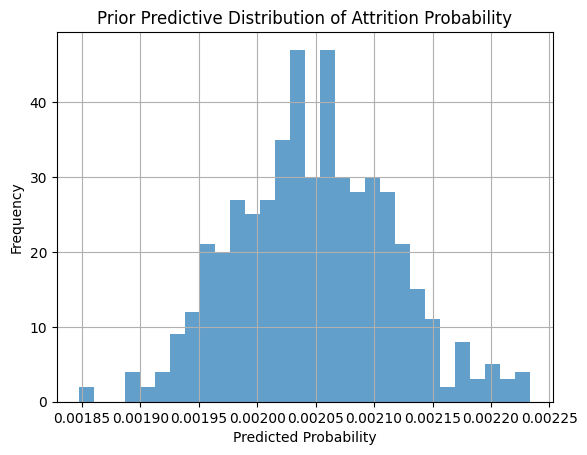

[Step 0] ELBO: 724.97
[Step 1000] ELBO: 652.48
[Step 2000] ELBO: 650.00
[Step 3000] ELBO: 650.09
[Step 4000] ELBO: 650.26
[Step 5000] ELBO: 649.83
[Step 6000] ELBO: 649.90
[Step 7000] ELBO: 650.09
[Step 8000] ELBO: 649.93
[Step 9000] ELBO: 649.92
[Step 10000] ELBO: 650.04
[Step 11000] ELBO: 650.06
[Step 12000] ELBO: 649.85
[Step 13000] ELBO: 650.22
[Step 14000] ELBO: 649.38
[Step 15000] ELBO: 650.01
[Step 16000] ELBO: 649.89
[Step 17000] ELBO: 649.69
[Step 18000] ELBO: 649.94
[Step 19000] ELBO: 649.94
[Step 20000] ELBO: 650.16
[Step 21000] ELBO: 650.00
[Step 22000] ELBO: 649.98
[Step 23000] ELBO: 650.32
[Step 24000] ELBO: 650.30
[Step 25000] ELBO: 650.09
[Step 26000] ELBO: 650.06
[Step 27000] ELBO: 650.07
[Step 28000] ELBO: 650.33
[Step 29000] ELBO: 649.66
[Step 30000] ELBO: 649.99
[Step 31000] ELBO: 649.81
[Step 32000] ELBO: 650.29
[Step 33000] ELBO: 649.83
[Step 34000] ELBO: 650.10
[Step 35000] ELBO: 649.98
[Step 36000] ELBO: 649.87
[Step 37000] ELBO: 650.10
[Step 38000] ELBO: 649.88

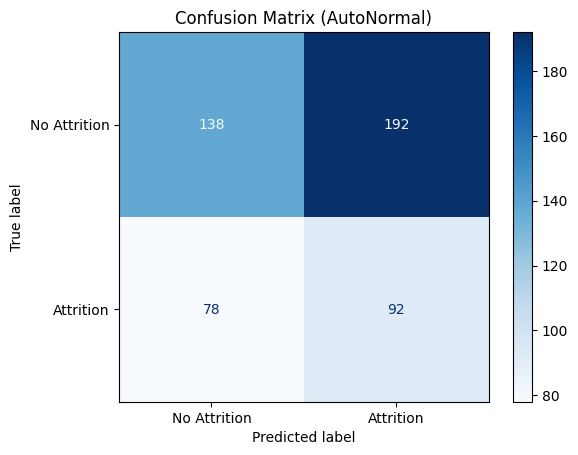

In [75]:
# Model definition
def model(X, n_cat, y=None):
    n_features = X.shape[1]

    beta = pyro.sample("beta", dist.Normal(0., 1.).expand([n_features, 1]).to_event(2)) # Priors
    intercept = pyro.sample("intercept", dist.Normal(log_odds, 1.0)) # Intercept prior guided by class balance
    logits = X @ beta + intercept  # shape: (N, 1), input features to the bernouli

    with pyro.plate("data", X.shape[0]):
        y = pyro.sample("y", dist.Bernoulli(logits=logits.squeeze(-1)), obs=y)
    
    return y

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).bool()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).bool()

prior_pred = Predictive(model, num_samples=1000)
prior_samples = prior_pred(X_test, n_cat=None, y=None)
logits_prior = X_test @ prior_samples["beta"].mean(0) + prior_samples["intercept"].mean()
probs_prior = torch.sigmoid(logits_prior)

plt.hist(probs_prior.detach().numpy().flatten(), bins=30, alpha=0.7)
plt.title("Prior Predictive Distribution of Attrition Probability")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Clear previous state
pyro.clear_param_store()

# Define guide
guide = AutoNormal(model)

# Optimizer and ELBO
optimizer = ClippedAdam({"lr": 0.001})
elbo = Trace_ELBO()
svi = SVI(model, guide, optimizer, loss=elbo)

# Training loop
n_steps = 40000
for step in range(n_steps):
    loss = svi.step(X_train, n_cat=None, y=y_train.float())
    if step % 1000 == 0:
        print(f"[Step {step}] ELBO: {loss:.2f}")

predictive = Predictive(model, guide=guide, num_samples=1000, return_sites=("beta",))
samples = predictive(X_test, n_cat=None, y=None)  # no y because we want predictions

beta_samples = samples["beta"].detach().squeeze()  # shape: (1000, D)
print("beta_samples shape:", beta_samples.shape)

beta_mean = beta_samples.mean(0)  # shape: (D,)

logits_test = X_test @ beta_mean
probs_test = torch.sigmoid(logits_test)
y_pred = (probs_test > 0.5).int()

accuracy = (y_pred == y_test.int()).float().mean()
print(f"Test Accuracy: {accuracy:.3f}")

cm = confusion_matrix(y_test.numpy(), y_pred.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Attrition", "Attrition"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (AutoNormal)")
plt.show()

### COMBINED

X_train shape: torch.Size([970, 46]), y_train shape: torch.Size([970])
[Step 0] ELBO: 75744.86
[Step 1000] ELBO: 61468.72
[Step 2000] ELBO: 61468.71
[Step 3000] ELBO: 61465.31
[Step 4000] ELBO: 61463.12
[Step 5000] ELBO: 61477.59
[Step 6000] ELBO: 61480.50
[Step 7000] ELBO: 61442.34
[Step 8000] ELBO: 61436.23
[Step 9000] ELBO: 61425.01
[Step 10000] ELBO: 61447.64
[Step 11000] ELBO: 61427.29
[Step 12000] ELBO: 61445.71
[Step 13000] ELBO: 61453.53
[Step 14000] ELBO: 61430.41
[Step 15000] ELBO: 61431.10
[Step 16000] ELBO: 61452.85
[Step 17000] ELBO: 61415.07
[Step 18000] ELBO: 61417.55
[Step 19000] ELBO: 61415.90
[Step 20000] ELBO: 61437.72
[Step 21000] ELBO: 61453.61
[Step 22000] ELBO: 61442.76
[Step 23000] ELBO: 61462.00
[Step 24000] ELBO: 61395.64
[Step 25000] ELBO: 61450.32
[Step 26000] ELBO: 61457.84
[Step 27000] ELBO: 61442.84
[Step 28000] ELBO: 61406.87
[Step 29000] ELBO: 61429.53
[Step 30000] ELBO: 61436.66
[Step 31000] ELBO: 61410.14
[Step 32000] ELBO: 61421.62
[Step 33000] ELBO:

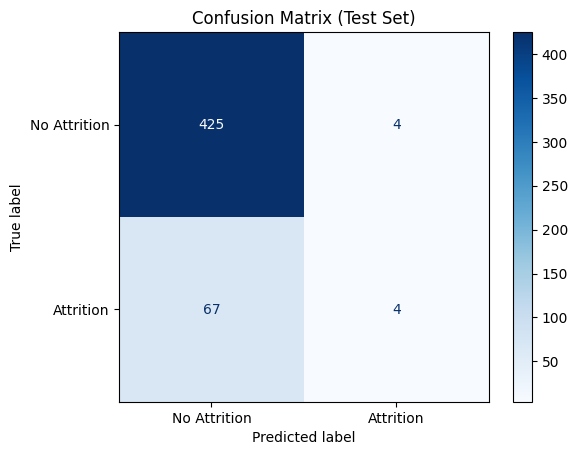

In [82]:
np.random.seed(42)

# Standardize safely
X_np = data.to_numpy()
X_mean = np.nanmean(X_np, axis=0)
X_std = np.nanstd(X_np, axis=0)
X_std[X_std == 0] = 1.0
X_np = (X_np - X_mean) / X_std
X_np = np.nan_to_num(X_np, nan=0.0, posinf=0.0, neginf=0.0)

# Split the data
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X_np, target, train_size=0.66, random_state=42)

X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np.to_numpy(), dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np.to_numpy(), dtype=torch.float32)

N_train, D = X_train.shape
latent_dim = 7  # Known from running PPCA seperatelt

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

def combined_ppca_blr_model(X, y=None):
    N, D = X.shape
    
    # PPCA parameters
    W = pyro.sample("W", dist.Normal(0, 1).expand([D, latent_dim]).to_event(2))
    sigma = pyro.sample("sigma", dist.HalfCauchy(1))
    
    # Logistic regression parameters
    beta = pyro.sample("beta", dist.Normal(0., 1.).expand([latent_dim]).to_event(1))
    intercept = pyro.sample("intercept", dist.Normal(0., 1.))
    
    with pyro.plate("data", N):
        z = pyro.sample("z", dist.Normal(0, 1).expand([latent_dim]).to_event(1))
        
        # Generate X
        loc = torch.matmul(z, W.mT)
        pyro.sample("obs_X", dist.Normal(loc, sigma).to_event(1), obs=X)
        
        # Generate y
        logits = (z * beta).sum(-1) + intercept
        pyro.sample("obs_y", dist.Bernoulli(logits=logits), obs=y)

def ppca_encoder(X, W, sigma):
    D, latent_dim = W.shape
    N = X.shape[0]
    WtW = W.T @ W
    cov_z_inv = WtW + sigma**2 * torch.eye(latent_dim)
    cov_z = torch.inverse(cov_z_inv)
    z_mean = (cov_z @ W.T @ X.T).T
    return z_mean

pyro.clear_param_store()
guide = AutoNormal(combined_ppca_blr_model)
optimizer = Adam({"lr": 0.01})
svi = SVI(combined_ppca_blr_model, guide, optimizer, loss=Trace_ELBO())

num_steps = 40000
for step in range(num_steps):
    loss = svi.step(X_train, y_train)
    if step % 1000 == 0:
        print(f"[Step {step}] ELBO: {loss:.2f}")

# Posterior inference using the guide (train set)
posterior_samples = guide(X_train, y_train)
W_mean = posterior_samples['W']
sigma_mean = posterior_samples['sigma']
beta_mean = posterior_samples['beta']
intercept_mean = posterior_samples['intercept']

# Use ppca_encoder for z_test
z_test_encoded = ppca_encoder(X_test, W_mean, sigma_mean)

# Predict on test set
logits_test = (z_test_encoded * beta_mean).sum(-1) + intercept_mean
probs_test = torch.sigmoid(logits_test)
y_pred_test = (probs_test > 0.5).int()

# Accuracy on test set
accuracy_test = (y_pred_test == y_test.int()).float().mean()
print(f"Test Accuracy: {accuracy_test:.3f}")

# Confusion matrix for test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test.numpy(), y_pred_test.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Attrition", "Attrition"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.show()

In [86]:
print(classification_report(y_test.numpy(), y_pred_test.numpy(), target_names=["No Attrition", "Attrition"]))

              precision    recall  f1-score   support

No Attrition       0.86      0.99      0.92       429
   Attrition       0.50      0.06      0.10        71

    accuracy                           0.86       500
   macro avg       0.68      0.52      0.51       500
weighted avg       0.81      0.86      0.81       500

